In [6]:
from pycaret.regression import load_model, predict_model
import pandas as pd
from ax.service.managed_loop import optimize
import numpy as np

In [2]:
# 1. pycaret에서 기존에 구축한 모델 불러오기
model_R = load_model('et_saved_220525_test3')
model_P = load_model('et2_saved_220525_test3')
model_V = load_model('et3_saved_220525_test3')
# Load the test data from CSV into a DataFrame
test_df = pd.read_csv('Test_data_ML-R9_220516_test3_MW.csv', encoding='cp949')

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [3]:
# 2. 모델이 잘 불러왔는지, 작동하는지 테스트 (test 데이터 csv를 이용)
# test_results = predict_model(model_R, data=test_df)
# print(test_results.head())
# test_results = predict_model(model_P, data=test_df)
# print(test_results.head())
# test_results = predict_model(model_V, data=test_df)
# print(test_results.head())

In [11]:
# 3. Bayesian optimization을 이용하여, objective function 최대화
# input data 불러오기
input_df = pd.read_csv('Bays_data_initial 10_251007.csv', encoding='cp949')

# base와 columns 정의
base = input_df.iloc[0].copy()
columns = input_df.columns

def pycaret_predict(params):
    # 파라미터 매핑
    param_map = {
        "Feed_rate_SLPM": "Feed rate (SLPM)",
        "Rinse_rate_SLPM": "Rinse rate (SLPM)",
        "Pad_bar": "Pad (bar)",
        "Pde_bar": "Pde (bar)"
    }
    updated_base = base.copy()
    for k, v in params.items():
        updated_base[param_map[k]] = v
    input_row_updated = {col: updated_base[col] for col in columns}
    input_df_pred = pd.DataFrame([input_row_updated])

    # 모델 예측
    pred_R = predict_model(model_R, data=input_df_pred)
    pred_P = predict_model(model_P, data=input_df_pred)
    pred_V = predict_model(model_V, data=input_df_pred)

    # obj 계산 (이전 논문 참조)
    Feed_CO = 0.2 * input_df_pred['Feed rate (SLPM)'] * 60 / (10**3 * 0.082057 * 273.15)
    Product_CO = Feed_CO * pred_R['prediction_label'] / 100
    k_comp = 1.4 * (0.517 + 0.253) + 1.28 * 0.23
    k_vc = 1.4
    mu = 0.75
    Feed_Compressor = 2.78e-4 * k_comp / (k_comp - 1) * 100 * input_df_pred['Pad (bar)'] / mu / mu / input_df_pred['Pad (bar)'] ** ((k_comp - 1) / k_comp - 1)
    Rinse_Compressor = 2.78e-4 * k_vc / (k_vc - 1) * 100 * input_df_pred['Pad (bar)'] / mu / mu / input_df_pred['Pad (bar)'] ** ((k_vc - 1) / k_vc - 1)
    Vacuum_Pump = 2.78e-4 * k_vc / (k_vc - 1) * 100 * mu / mu / (1 / input_df_pred['Pde (bar)']) ** ((k_vc - 1) / k_vc - 1)
    Electricity = Feed_Compressor + Rinse_Compressor * (input_df_pred['Rinse rate (SLPM)'] / input_df_pred['Feed rate (SLPM)']) + Vacuum_Pump * (pred_V['prediction_label'] / input_df_pred['Feed rate (SLPM)'])

    CO_Low = (pred_P['prediction_label'] / 100) * (2411 / 11000) * 0.528
    CO_High = 15.49008 * np.exp(0.75093 * (pred_P['prediction_label'] - 98))
    CO_Price = np.maximum(CO_Low, CO_High)

    Fee_gas = (20 / 100) * (2411 / 11000) * 0.528
    Elec_price = 0.1
    Propit = CO_Price * Product_CO * 22.4
    Cost = input_df_pred['Feed rate (SLPM)'] * (60 / 10**3) * Fee_gas
    Opex = (60 / 10**3) * input_df_pred['Feed rate (SLPM)'] * Electricity * Elec_price

    obj = Propit - Cost - Opex
    return obj.iloc[0]

best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "Feed_rate_SLPM", "type": "range", "bounds": [1.0, 10.0]},
        {"name": "Rinse_rate_SLPM", "type": "range", "bounds": [0.5, 2.4]},
        {"name": "Pad_bar", "type": "range", "bounds": [2.5, 6.4]},
        {"name": "Pde_bar", "type": "range", "bounds": [0.05, 0.15]},
    ],
    evaluation_function=pycaret_predict,
    minimize=False,
    total_trials=20,
)

print("Best parameters found:", best_parameters)
print("Best objective value:", values)

[INFO 10-07 16:54:50] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter Feed_rate_SLPM. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 10-07 16:54:50] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter Rinse_rate_SLPM. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 10-07 16:54:50] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter Pad_bar. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 10-07 16:54:50] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter Pde_bar. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or

[INFO 10-07 16:54:50] ax.service.managed_loop: Running optimization trial 2...
[INFO 10-07 16:54:51] ax.service.managed_loop: Running optimization trial 3...
[INFO 10-07 16:54:52] ax.service.managed_loop: Running optimization trial 4...
[INFO 10-07 16:54:53] ax.service.managed_loop: Running optimization trial 5...
[INFO 10-07 16:54:54] ax.service.managed_loop: Running optimization trial 6...
[INFO 10-07 16:54:55] ax.service.managed_loop: Running optimization trial 7...
[INFO 10-07 16:54:55] ax.service.managed_loop: Running optimization trial 8...
[INFO 10-07 16:54:56] ax.service.managed_loop: Running optimization trial 9...
[INFO 10-07 16:55:28] ax.service.managed_loop: Running optimization trial 10...
[INFO 10-07 16:56:52] ax.service.managed_loop: Running optimization trial 11...
[INFO 10-07 16:57:24] ax.service.managed_loop: Running optimization trial 12...
[INFO 10-07 16:58:02] ax.service.managed_loop: Running optimization trial 13...
[INFO 10-07 16:58:18] ax.service.managed_loop: R

Best parameters found: {'Feed_rate_SLPM': 10.0, 'Rinse_rate_SLPM': 1.8859838333675485, 'Pad_bar': 4.444785749725115, 'Pde_bar': 0.05}
Best objective value: ({'objective': 4.4803571403054026}, {'objective': {'objective': 0.006790305116085314}})


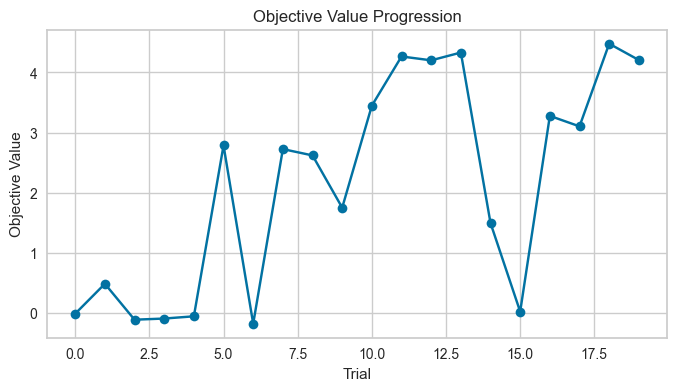

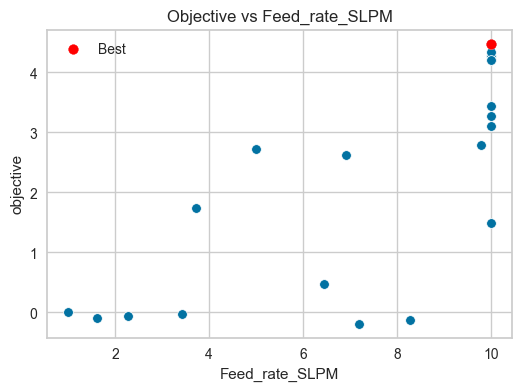

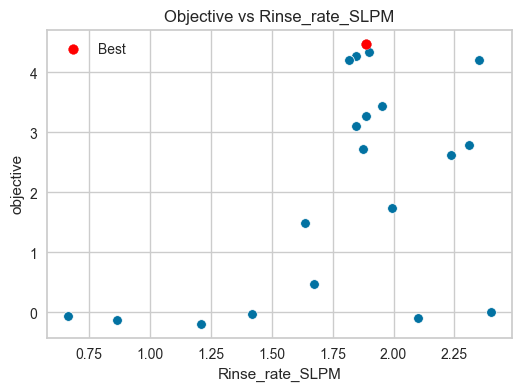

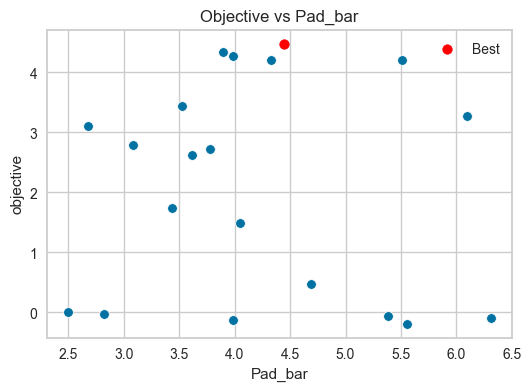

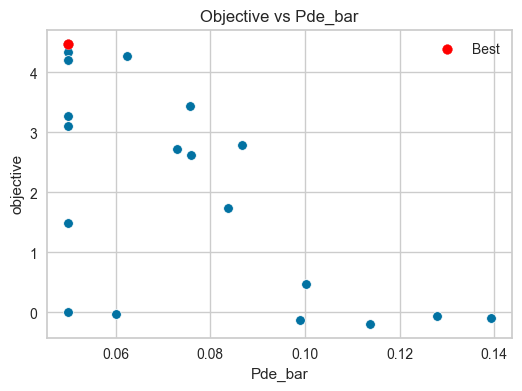

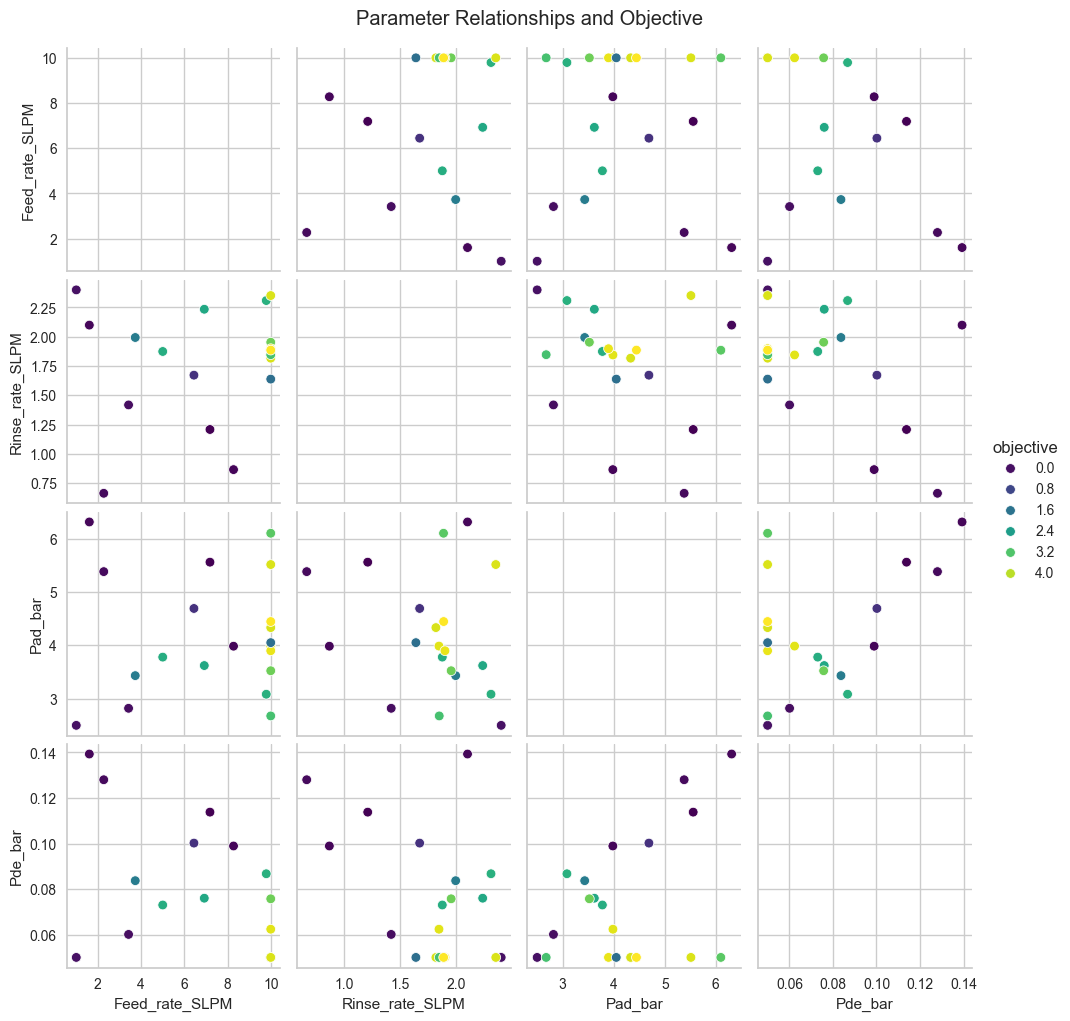

In [14]:
import seaborn as sns

import matplotlib.pyplot as plt

# 1. Objective 값의 변화 추이
objective_values = [trial.objective_mean for trial in experiment.trials.values()]
plt.figure(figsize=(8,4))
plt.plot(objective_values, marker='o')
plt.xlabel('Trial')
plt.ylabel('Objective Value')
plt.title('Objective Value Progression')
plt.show()

# 2. 파라미터별 Objective 값 분포
results = []
for trial in experiment.trials.values():
    params = trial.arm.parameters
    obj = trial.objective_mean
    params['objective'] = obj
    results.append(params)
results_df = pd.DataFrame(results)

param_names = ['Feed_rate_SLPM', 'Rinse_rate_SLPM', 'Pad_bar', 'Pde_bar']
for param in param_names:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=results_df, x=param, y='objective')
    plt.scatter(best_parameters[param], values[0]['objective'], color='red', label='Best', zorder=5)
    plt.title(f'Objective vs {param}')
    plt.legend()
    plt.show()

# 3. Pairplot
sns.pairplot(results_df, vars=param_names, hue='objective', palette='viridis')
plt.suptitle('Parameter Relationships and Objective', y=1.02)
plt.show()